# Propensity Score Matching

In [150]:
#Import basic libariaries
%matplotlib inline
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from causalinference import CausalModel


In [151]:
control=pd.read_stata('cps_controls.dta')
control=control.append(pd.read_stata('psid_controls.dta'))
control.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [152]:
type(control)

pandas.core.frame.DataFrame

In [153]:
#check the length
len(control)

18482

In [154]:
control.columns=['ID','Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']


In [155]:
control.head()

,ID,Treated,Age,Education,Black,Hispanic,Married,Nodegree,RE74,RE75,RE78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [156]:
names = ['Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']

treated = pd.read_table('nswre74_treated.txt', sep = '\s+',
                        header = None, names = names)

treated['ID']='nswre74_treat'

In [157]:
data = pd.concat([treated, control],sort=True)
data['u74'] = (data.RE74 == 0).astype(np.int32)
data['u75'] = (data.RE75 == 0).astype(np.int32)

In [158]:
data.tail()

,Age,Black,Education,Hispanic,ID,Married,Nodegree,RE74,RE75,RE78,Treated,u74,u75
2485,47.0,0.0,8.0,0.0,PSID,1.0,1.0,44667.363281,33837.097656,38568.664062,0.0,0,0
2486,32.0,0.0,8.0,0.0,PSID,1.0,1.0,47022.402344,67137.093750,59109.062500,0.0,0,0
2487,47.0,0.0,10.0,0.0,PSID,1.0,1.0,48197.964844,47968.113281,55710.292969,0.0,0,0
2488,54.0,0.0,0.0,1.0,PSID,1.0,1.0,49228.539062,44220.968750,20540.398438,0.0,0,0
2489,40.0,0.0,8.0,0.0,PSID,1.0,1.0,50940.937500,55500.000000,53198.156250,0.0,0,0


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


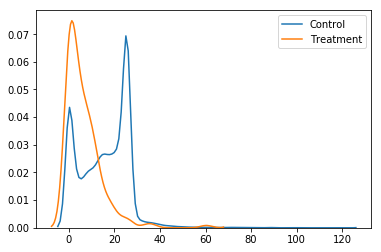

In [159]:
data[['RE74_div', 'RE75_div', 'RE78_div']] = data[['RE74', 'RE75', 'RE78']] / 1000


sns.kdeplot(data[data.Treated == 0].RE78_div, label='Control')
sns.kdeplot(data[data.Treated == 1].RE78_div, label='Treatment')

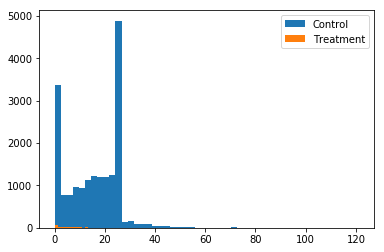

In [160]:
plt.hist(data[data.Treated == 0].RE78_div, label='Control', bins=50);
plt.hist(data[data.Treated == 1].RE78_div, label='Treatment', bins=50);
plt.legend();

In [161]:
data.columns

Index(['Age', 'Black', 'Education', 'Hispanic', 'ID', 'Married', 'Nodegree',
       'RE74', 'RE75', 'RE78', 'Treated', 'u74', 'u75', 'RE74_div', 'RE75_div',
       'RE78_div'],
      dtype='object')

In [162]:
causal_model = CausalModel(
    X=data[['Age', 'Education', 'Black', 'Hispanic', 'Married','Nodegree', 'RE74_div', 'RE75_div']].values,
    D=data.Treated.values,
    Y=data.RE78_div.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()

print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)


Summary Statistics

                       Controls (N_c=531)         Treated (N_t=151)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        4.984        7.957        6.021        7.957        1.037

                       Controls (N_c=531)         Treated (N_t=151)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       28.175       11.837       25.728        7.344       -0.248
             X1       10.458        2.802       10.238        2.061       -0.089
             X2        0.902        0.297        0.967        0.180        0.264
             X3        0.098        0.297        0.033        0.180       -0.264
             X4        0.303        0.460        0.139        0.347       -0.403
      

/anaconda3/lib/python3.7/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]
/anaconda3/lib/python3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
/anaconda3/lib/python3.7/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``

In [163]:
# We run three models and see positive treatment effects in each one;
# though only 2 are "significant", which can be seen in the "ATE" output lines


In [164]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [166]:
from patsy import dmatrices
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [183]:
# create propensity score estimates
_, X_propensity = dmatrices(propensity_formula, data, return_type='dataframe')
propensities = propensity_model.predict(exog=X_propensity)

split = control.shape[0]

treatment = np.expand_dims(propensities[split:], 1)
Control = np.expand_dims(propensities[:split], 1)

# Calculating the distance in propensity of each treatment sample to each control sample
distances = cdist(treatment, Control)

# Computing an optimal match between the two groups
treatment_idx, control_idx = linear_sum_assignment(distances)

treatment_data = data[split:].iloc[treatment_idx]
control_data = data[:split].iloc[control_idx]

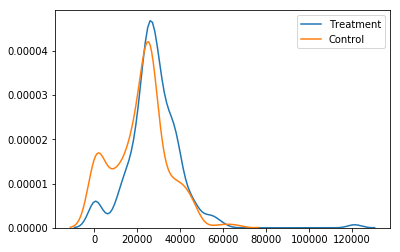

In [184]:
sns.kdeplot(treatment_data.RE78, label='Treatment')
sns.kdeplot(control_data.RE78, label='Control')

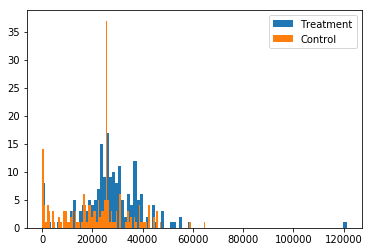

In [185]:
plt.hist(treatment_data.RE78, label='Treatment', bins=100)
plt.hist(control_data.RE78, label='Control', bins=100)
plt.legend();

In [198]:
# we see that the control group doesn't overwhelm our treatment group like it did before, the graphs are similar